<a href="https://colab.research.google.com/github/jovanape/Bitcoint-Price-Prediction/blob/main/08_RNN_scaled_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predviđanje vrednosti bitkoina korišćenjem RNN**

**Korišćeni atributi:** Open, High, Low, Close

**Filtrirani podaci:** od 28.03.2021.

Ova sveska je slična prethodnoj (svesci "rnn_scaled_dataset.ipynb"), sa razlikom što je ovde pokušano skaliranje trening, validacionog i test skupa pre određivanja ciljne promenljive. Posledica ovog postupka je to da predviđene vrednosti nisu izražene na istoj skali kao date vrednosti podataka.

## **Učitavanje biblioteka**

In [26]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras import callbacks
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

#%run 02_Preprocessing_and_data_analysis.ipynb
#%run 03_Utility_functions.ipynb

## **Učitavanje skupa podataka i pretprocesiranje**

In [27]:
def preprocess_data(file_name = 'bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv'):

  # Ucitavanje skupa podataka
  data = pd.read_csv(file_name)
  #print('Prvih 5 instanci skupa podataka pre sredjivanja:\n', data.head(5))

  # Dimenzije DataFrame-a
  #print('\n\nDimenzije skupa podataka pre sredjivanja:\n', data.shape)

  # Ciscenje podataka od NaN vrednosti
  data = data.dropna()

  # Kreiranje datuma
  data['Date'] = pd.to_datetime(data['Timestamp'], unit='s').dt.date # samo datum (bez vremena)
  #print('\n\nPrvih 5 instanci skupa podataka nakon sredjivanja:\n', data.head(5))

  # Dimenzije DataFrame-a
  #print('\n\nDimenzije skupa podataka nakon sredjivanja:\n', data.shape)

  return data

data = preprocess_data(file_name = 'bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')

In [28]:
def filter_data(data, date_str = '2021-03-28'):
    
    # Filtriranje podataka
    data = data.loc[data['Date'] > pd.to_datetime(date_str)]
    #print('\nPrvih 5 instanci skupa podataka nakon filtriranja:\n', data.head(5))

    # Dimenzije DataFrame-a
    #print('\n\nDimenzije skupa podataka nakon filtriranja:\n', data.shape)
    
    return data

# Filtriranje podataka

data = filter_data(data, date_str = '2021-03-28')

In [29]:
data

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Date
4854496,1616976000,55790.28,55822.98,55777.98,55804.36,1.731449,96636.546983,55812.518695,2021-03-29
4854497,1616976060,55822.98,55857.28,55822.98,55857.28,0.589603,32931.781301,55854.182542,2021-03-29
4854498,1616976120,55822.98,55829.04,55766.15,55779.04,2.729659,152263.034630,55780.964698,2021-03-29
4854500,1616976240,55766.15,55768.63,55766.15,55768.63,0.023738,1323.776861,55766.455065,2021-03-29
4854501,1616976300,55770.46,55778.48,55736.83,55742.20,0.389067,21692.454676,55755.006032,2021-03-29
...,...,...,...,...,...,...,...,...,...
4857372,1617148560,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339,2021-03-30
4857373,1617148620,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508,2021-03-30
4857374,1617148680,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496,2021-03-30
4857375,1617148740,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202,2021-03-30


### **Podela skupa podataka**

In [30]:
def data_split(data, test_size = 0):

  if test_size <= 0:
    print('Vrednost parametra test_size mora biti strogo veca od 0.\n')
    return
  else: # test_size > 0
    test_limit = len(data) - int(test_size * len(data))

  train = data[:test_limit]
  test = data[test_limit:]
  
  return train, test

# Podela inicijalnog skupa podataka na train i test skup

train, test = data_split(data, test_size = 0.2)


# Podela train skupa podataka na train i validacioni skup

train, validation = data_split(train, test_size = 0.2)

In [31]:
# Dimenzije train, validation i test skupa

train.shape, validation.shape, test.shape

((1839, 9), (459, 9), (574, 9))

### **Vizualizacija validacionog skupa i trening skupa**

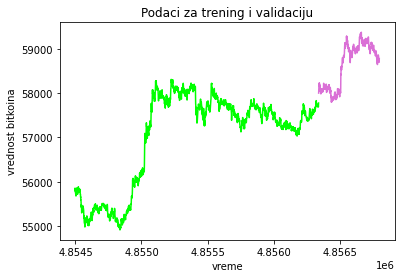

In [32]:
def plot_train_and_validation_data(train, validation):
  plt.title('Podaci za trening i validaciju')
  plt.xlabel('vreme')
  plt.ylabel('vrednost bitkoina')
  plt.plot(train, c = 'lime')
  plt.plot(validation, c = 'orchid')
  plt.show()
  
plot_train_and_validation_data(train = train['Close'], validation = validation['Close'])

### **Filtriranje trening, validacionog i test skupa**

In [33]:
# Izbacivanje nepotrebnih kolona (atributa) iz trening skupa

train_ = train.drop(['Date', 'Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price', 'Timestamp'], axis = 1)
# train_.head(), train_.shape

In [34]:
# Izbacivanje nepotrebnih kolona (atributa) iz validacionog skupa

validation_ = validation.drop(['Date', 'Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price', 'Timestamp'], axis = 1)
# validation_.head(), validation_.shape

In [35]:
# Izbacivanje nepotrebnih kolona (atributa) iz test skupa

test_ = test.drop(['Date', 'Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price', 'Timestamp'], axis = 1)
# test_.head(), test_.shape

In [36]:
# Dimenzije train skupa - pre i nakon izbacivanja atributa

# train.shape, train_.shape

### **Skaliranje**

In [37]:
scaler = MinMaxScaler(feature_range=(0, 1))

train_ = scaler.fit_transform(train_)
validation_ = scaler.transform(validation_)
test_ = scaler.transform(test_)

### **Odredjivanje ciljne promenljive**

In [38]:
def determine_x_and_y(dataset):
  X = []
  y = []

  df = pd.DataFrame()

  for i in range(60, dataset.shape[0]):
    X.append(dataset[i-60:i])
    y.append(dataset[i,0])
  
  return X, y

# Odredjivanje ciljne promenljive na train skupu

X_train, y_train = determine_x_and_y(dataset = train_)


# Odredjivanje ciljne promenljive na validacionom skupu

X_validation, y_validation = determine_x_and_y(dataset = validation_)


# Odredjivanje ciljne promenljive na test skupu

X_test, y_test = determine_x_and_y(dataset = test_)

In [39]:
# type(X_train), type(y_train)

In [40]:
# Konverzija u np.array

X_train, y_train = np.array(X_train), np.array(y_train)
X_validation, y_validation = np.array(X_validation), np.array(y_validation)
X_test, y_test = np.array(X_test), np.array(y_test)

In [41]:
# Dimenzije X_train

# X_train.shape, y_train.shape, X_validation.shape, y_validation.shape, X_test.shape, y_test.shape

### **Kreiranje, kompilacija i treniranje mreže**

**Kreiranje mreže**

In [42]:
# Definicija funkcije koja kreira i vraca model mreze

def build_net(input_1 = X_train.shape[1], input_2 = X_train.shape[2]):

  net = Sequential()
  net.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (input_1, input_2)))
  net.add(Dropout(0.2))
  net.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
  net.add(Dropout(0.3))

  net.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
  net.add(Dropout(0.4))

  net.add(LSTM(units = 120, activation = 'relu'))
  net.add(Dropout(0.5))

  net.add(Dense(units =1))
  print(net.summary())

  return net


In [43]:
# Kreiranje modela mreze

net = build_net(input_1 = X_train.shape[1], input_2 = X_train.shape[2])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            11000     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 60)            26640     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 60)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 80)            45120     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 80)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 120)               9

**Kompilacija i treniranje mreže**

In [44]:

def compile_and_fit(net, optimizer, loss, metrics, X_train, y_train, epochs, batch_size, validation = 1, validation_data = None, patience = 3):

  net.compile(optimizer = optimizer, loss = loss, metrics = metrics)

  callback = callbacks.EarlyStopping(monitor = 'loss', patience = patience)

  if validation == 0: # bez validacije
    history = net.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, callbacks=[callback])
  else: # sa validacijom
    history = net.fit(X_train, y_train, epochs = epochs, validation_data = validation_data, batch_size = batch_size, callbacks=[callback])

  return history, net

# Kompilacija i treniranje mreze bez validacije

history_no_validation, net_no_validation = compile_and_fit(net, optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mse', 'mae'], X_train = X_train, y_train = y_train, epochs = 20, batch_size = 50, validation = 0, patience = 3)


# Kompilacija i treniranje mreze sa validacijom

validation_data = (X_validation, y_validation)

history_validation, net_validation = compile_and_fit(net, optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mse', 'mae'], X_train = X_train, y_train = y_train, epochs = 20, batch_size = 50, validation = 1, validation_data = validation_data, patience = 3)


Epoch 1/20
36/36 [==============================] - 10s 179ms/step - loss: 0.1574 - mse: 0.1574 - mae: 0.3200
Epoch 2/20
36/36 [==============================] - 6s 173ms/step - loss: 0.0307 - mse: 0.0307 - mae: 0.1453
Epoch 3/20
36/36 [==============================] - 6s 173ms/step - loss: 0.0183 - mse: 0.0183 - mae: 0.1033
Epoch 4/20
36/36 [==============================] - 6s 174ms/step - loss: 0.0157 - mse: 0.0157 - mae: 0.0941
Epoch 5/20
36/36 [==============================] - 6s 175ms/step - loss: 0.0138 - mse: 0.0138 - mae: 0.0892
Epoch 6/20
36/36 [==============================] - 6s 175ms/step - loss: 0.0128 - mse: 0.0128 - mae: 0.0848
Epoch 7/20
36/36 [==============================] - 6s 172ms/step - loss: 0.0125 - mse: 0.0125 - mae: 0.0846
Epoch 8/20
36/36 [==============================] - 6s 169ms/step - loss: 0.0105 - mse: 0.0105 - mae: 0.0781
Epoch 9/20
36/36 [==============================] - 6s 177ms/step - loss: 0.0110 - mse: 0.0110 - mae: 0.0802
Epoch 10/20
36/36 

### **Predvidjanje**

In [45]:
# Predvidjanje za mrezu treniranu bez i sa validacijom

# Bez validacije
y_predicted_no_validation = net_no_validation.predict(X_test)
#print('Predvidjene vrednosti - bez validacije:\n', y_predicted_no_validation)

# Sa validacijom
y_predicted_validation = net_validation.predict(X_test)
#print('\nPredvidjene vrednosti - sa validacijom:\n', y_predicted_validation)

### **Vizualizacija rezultata predvidjanja**

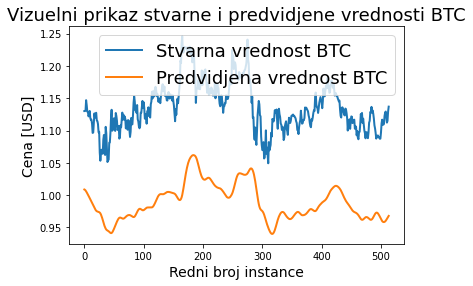

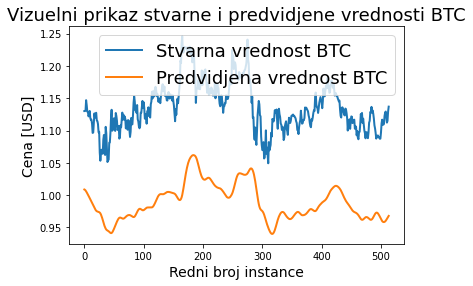

In [46]:
def plot_real_vs_predicted_data(test_set, predicted_set):
  
  plt.plot(test_set, label='Stvarna vrednost BTC', linewidth=2)
  plt.plot(predicted_set, label='Predvidjena vrednost BTC', linewidth=2)
  plt.xlabel('Redni broj instance', fontsize=14)
  plt.ylabel('Cena [USD]', fontsize=14)
  plt.title(label = 'Vizuelni prikaz stvarne i predvidjene vrednosti BTC', fontsize=18)
  plt.legend(loc='best', fontsize=18)
  plt.show()


# Plotovanje stvarne i predvidjene vrednosti

# Bez validacije
plot_real_vs_predicted_data(test_set = y_test, predicted_set = y_predicted_no_validation)

# Sa validacijom
plot_real_vs_predicted_data(y_test, y_predicted_validation)

### **Vizualizacija metrika**

### **Funkcija gubitka**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


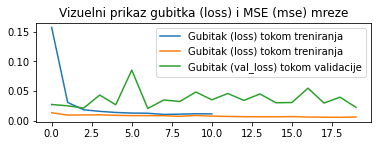

In [47]:

def plot_loss(history_):

  epochs = range(len(history_.history['loss'])) # broj epoha

  plt.title('Vizuelni prikaz gubitka (loss) i MSE (mse) mreze')

  plt.subplot(211)
  
  plt.plot(epochs, history_.history['loss'], label='Gubitak (loss) tokom treniranja')

  if 'val_loss' in history_.history:
    plt.plot(epochs, history_.history['val_loss'], label='Gubitak (val_loss) tokom validacije')
  
  plt.legend()


# Vizuelni prikaz MSE

def plot_mse(history_):

  epochs = range(len(history_.history['mse'])) # broj epoha

  plt.title('Vizuelni prikaz srednjekvadratne greske (MSE) mreze')

  plt.subplot(212)

  plt.plot(epochs, history_.history['mse'], label='MSE (mse) tokom treniranja')
  
  if 'val_mse' in history_.history:
    plt.plot(epochs, history_.history['val_mse'], label='MSE (val_mse) tokom validacije')
  
  plt.legend()

  plt.show()


# Vizuelni prikaz MAE

def plot_mae(history_):

  epochs = range(len(history_.history['mae'])) # broj epoha
  plt.title('Vizuelni prikaz MAE (mae')
  plt.xlabel('broj epohe')
  plt.ylabel('MAE')
  
  plt.plot(epochs, history_.history['mae'], label='MAE (mae) tokom treniranja')

  if 'val_mae' in history_.history:
    plt.plot(epochs, history_.history['val_mae'], label='MAE (val_mae) tokom treniranja sa validacijom')

  plt.legend(loc = 'best')

  plt.show()

# Vizuelni prikaz funkcije gubitka tokom treniranja mreze

# Bez validacije
plot_loss(history_ = history_no_validation)

# Sa validacijom
plot_loss(history_ = history_validation)

### **Srednja kvadratna greška**

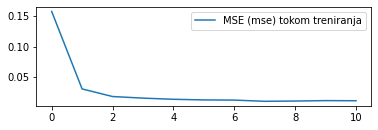

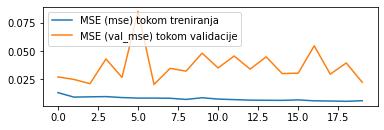

In [48]:
# Plotovanje srednje kvadratne greske tokom treniranja mreze

# Bez validacije
plot_mse(history_ = history_no_validation)

# Sa validacijom
plot_mse(history_ = history_validation)

### **Srednja apsolutna greška**

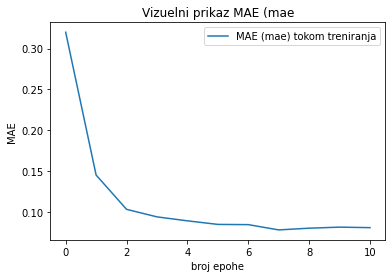

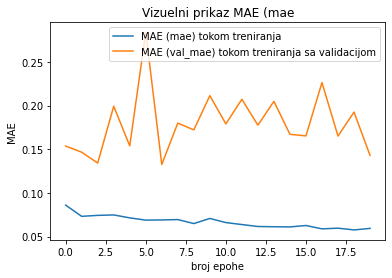

In [49]:
# Vizualizacija srednje apsolutne greske tokom treniranja mreze

# Bez validacije
plot_mae(history_no_validation)

# Sa validacijom
plot_mae(history_validation)

### **Loss, MSE, MAE**

In [50]:
# Loss, MSE, MAE nad skupom za testiranje

# (za model koji pri treniranju koristi validaciju
# i za model koji pri treniranju ne koristi validaciju)

test_metrics_no_val = net_no_validation.evaluate(X_test, y_test)
test_metrics_val = net_validation.evaluate(X_test, y_test)

print('\nMetrike prilikom testiranja - model treniran bez validacije\n')
print(net_no_validation.metrics_names[0], test_metrics_no_val[0])
print(net_no_validation.metrics_names[1], test_metrics_no_val[1])
print(net_no_validation.metrics_names[2], test_metrics_no_val[2])

print('\n\nMetrike prilikom testiranja - model treniran sa validacijom\n')
print(net_validation.metrics_names[0], test_metrics_val[0])
print(net_validation.metrics_names[1], test_metrics_val[1])
print(net_validation.metrics_names[2], test_metrics_val[2])

17/17 [==============================] - 1s 35ms/step - loss: 0.0220 - mse: 0.0220 - mae: 0.1462

Metrike prilikom testiranja - model treniran bez validacije

loss 0.021956132724881172
mse 0.021956132724881172
mae 0.1462184488773346


Metrike prilikom testiranja - model treniran sa validacijom

loss 0.021956132724881172
mse 0.021956132724881172
mae 0.1462184488773346


### **Koeficijent determinacije (R2 skor)**

In [51]:
# R2 skor nad skupom za testiranje
from sklearn import metrics

r2 = metrics.r2_score(y_predicted_no_validation, y_test)
r2_val = metrics.r2_score(y_predicted_validation, y_test)

print('R2 skor prilikom testiranja - model treniran bez validacije', r2)
print('R2 skor prilikom testiranja - model treniran sa validacijom', r2_val)

R2 skor prilikom testiranja - model treniran bez validacije -27.45953296386666
R2 skor prilikom testiranja - model treniran sa validacijom -27.45953296386666


In [52]:
# Cuvanje modela

net.save('rnn_model_02.hdf5')

Zakljucak

Prethodni model nije bio dobar, pa je pokusano sa drugacijim nacinom skaliranja. Ovaj model daje bolje rezultate od prethodnog.

Koeficijent determinacije je negativna vrednost, a trebao bi biti u intervalu [0, 1]. Metrike kao sto su loss, MAE, MSE imaju male vrednosti, sto je dobro.